# CycleGAN Practice Script

This notebook is created to implement a CycleGAN model and test its performance. The script is inspired by Udacity's cycle-gan exercise notebook on github (https://github.com/udacity/deep-learning-v2-pytorch/tree/master/cycle-gan). For convenience this script uses the helper functions provided by Udacity and is trained with the dataset recommended in Udacity's CycleGAN notebook(https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip). This implementation builds a structure that is easy to build customized models by specifying a dictionary. I find this technique suitable for me to easily modify models and let me have a better grasp of the structure of my models. In this implementation I specificly used fire modules used in SqueezeNet to show the ease of implementation with such architecture.

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import warnings

import torch.nn as nn
import torch.nn.functional as F

## Load and preprocess data

In [2]:
def get_loader(img_dir, character, transform, batch_size = 16, num_workers = 0):
	"""
	returns DataLoader with the specified image paths.
	Sample Usage: trainA_loader, testA_loader = get_loader('summer2winter_yosemite', 
						 'A', transform,
						 batch_size = 16,                                             
						 num_workers = 0)
	"""
	train_path = os.path.join(img_dir, ('train'+character))
	test_path = os.path.join(img_dir, ('test'+character))

	train_dataset = datasets.ImageFolder(train_path, transform)
	test_dataset = datasets.ImageFolder(test_path, transform)
	
	train_loader = DataLoader(dataset = train_dataset, 
				  batch_size = batch_size, 
				  shuffle = True, 
				  num_workers = num_workers)
	test_loader = DataLoader(dataset = test_dataset,
				 batch_size = batch_size,
				 shuffle = True,
				 num_workers = num_workers)
	return train_loader, test_loader

def get_data(img_dir, img_size = 128, batch_size = 16, num_workers = 0):
	"""
	Get data from the specified directory. The subdirectories in the image directory should have the following names: testA, testB, trainA, trainB
	Sample Usage: trainA_loader, testA_loader, trainB_loader, testB_loader = get_data('summer2winter_yosemite')
	"""
	transform = transforms.Compose([transforms.Resize(img_size),
					#transforms.Normalize((0,0,0), (0.5,0.5,0.5)),
					transforms.ToTensor()])
	
	trainA_loader, testA_loader = get_loader(img_dir, 
						 'A', transform,
						 batch_size = batch_size,                                             
						 num_workers = num_workers)
	trainB_loader, testB_loader = get_loader(img_dir,
						'B', transform,
						batch_size = batch_size,
						num_workers = num_workers)
	return trainA_loader, testA_loader, trainB_loader, testB_loader

# helper scale function
def scale(x, feature_range = (-1, 1)):
    """
    Scales feature x into the specified range
    Sample Usage: scale(x, feature_range = (-1, 1))
    """
    x = x*(feature_range[1] - feature_range[0])+feature_range[0]
    return x

In [3]:
img_dir = 'summer2winter_yosemite'
trainA_loader, testA_loader, trainB_loader, testB_loader = get_data(img_dir)

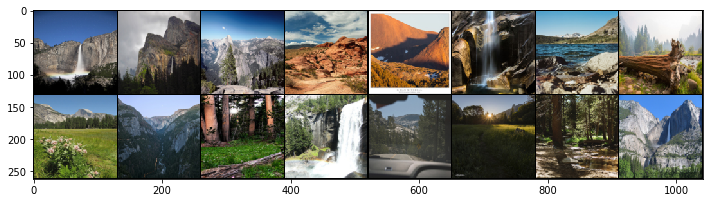

In [4]:

def imshow(img):
    """
    Transform given objects into numpy array and perform plt.imshow
    Sample usage:
    >>> dataiter = iter(trainA_loader)
    >>> images, _ = dataiter.next()
    >>> fig = plt.figure(figsize=(12, 8))
    >>> imshow(torchvision.utils.make_grid(images))
    """
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(trainA_loader)

images, _ = dataiter.next()

fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))


## Create Discriminator and Generator

In [5]:
"""
Define basic building blocks
"""
def linear(input_):
	return input_

def conv(params, batch_norm=True):
    """
    Creates a convolutional layer
    params should have the following structure:
    params = [in_channels, out_channels, kernel_size, stride, padding]
    Sample Usage: layers.append(conv(params))
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=params[0], out_channels=params[1],
                kernel_size=params[2], stride = params[3], padding=params[4], bias=False)
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(params[1]))
    return nn.Sequential(*layers)

def deconv(params, batch_norm=True):
    """
    Creates a deconvolutional layer
    params should have the following structure:
    params = [in_channels, out_channela, kernel_size, stride, padding]
    Sample Usage: layers.append(deconv(params))
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels=params[0], out_channels=params[1], 
                                     kernel_size=params[2], stride=params[3], padding=params[4], bias = False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(params[1]))
    return nn.Sequential(*layers)

class DeconvFires(nn.Module):    # bad class, should probably disregard it
    """
    Test Class, still under development and testing phase.
    """
    def __init__(self, params):
        super(DeconvFires, self).__init__()
        in_channels, out_channels, kernel_sizes, stride, padding = params
        kernel_size_1, kernel_size_2 = kernel_sizes
        self.deconv_layer_1 = deconv([in_channels, out_channels, kernel_size_1, stride, padding])
        self.deconv_layer_2 = deconv([in_channels, out_channels, kernel_size_2, stride, padding-1])
    def forward(self, x):
        out_1 = F.relu(self.deconv_layer_1(x))
        out_2 = F.relu(self.deconv_layer_2(x))
        return out_1 + out_2

class ResBlock(nn.Module):
    """
    Creates a ResBlock with the given parameters
    Sample Usage: layers.append(ResBlock(256))   # Creates a resblock with convolutional layers that has in_channels = 256, out_channels = 256
    """
    def __init__(self, conv_dim):
        super(ResBlock, self).__init__()
        params = [conv_dim, conv_dim, 3,1,1]
        self.conv_layer1 = conv(params, batch_norm = True)
        self.conv_layer2 = conv(params, batch_norm = True)
    def forward(self, x):
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2


class Fire(nn.Module):
    """
    Creates a Fire Module
    Sample Usage: layers.append(Fire(params))
    # params = [in_channels, squeeze_channels, expand1_channels, expand3_channels]
    """    
    def __init__(self, params):
        super(Fire, self).__init__()
        in_channels, squeeze_channels, expand1_channels, expand3_channels = params
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size = 1)
        self.expand1 = nn.Conv2d(squeeze_channels, expand1_channels, kernel_size = 1)
        self.expand3 = nn.Conv2d(squeeze_channels, expand3_channels, kernel_size=3, padding = 1)
    def forward(self, x):
        out_1 = F.relu(self.squeeze(x))
        out_2_1 = F.relu(self.expand1(out_1))
        out_2_3 = F.relu(self.expand3(out_1))
        out = torch.cat([out_2_1, out_2_3], 1)
        return out

In [6]:
class NetCreator(nn.Module):
	"""
	NetCreator accepts a given dictionary and generates a model given the dicitonary's specification.
	Sample Usage: G_AtoB = NetCreator(specs = dict_g)
	specs should be a list of dictionaries containing information about the network structure:
	e.g. spec = [['type':'conv', 'structure': [3,4,4], 'batch_norm':False, 'activation':F.relu],
		     ['type':'conv', 'structure': [4,3,4], 'batch_norm':False],...]
	"""
	def __init__(self, specs):
		super(NetCreator, self).__init__()
		default_conv_param = [None, None, 4,2,1] #kernel_size, stride, padding
		self.layers = nn.ModuleList()
		self.activations = []
		for spec in specs:
			if spec['type'] == 'conv':
				param = default_conv_param[:]
				param[:len(spec['structure'])] = spec['structure']
				if 'batch_norm' in spec.keys():
					self.layers.append(conv(param, batch_norm = spec['batch_norm']))
				else:
					self.layers.append(conv(param))
				if 'activation' in spec.keys():
					self.activations.append(spec['activation'])
				else:
					self.activations.append(F.relu)
			elif spec['type'] == 'deconv':
				param = default_conv_param[:]
				param[:len(spec['structure'])] = spec['structure']
				if 'batch_norm' in spec.keys():
					self.layers.append(deconv(param, batch_norm = spec['batch_norm']))
				else:
					self.layers.append(deconv(param))
				if 'activation' in spec.keys():
					self.activations.append(spec['activation'])
				else:
					self.activations.append(F.relu)
			elif spec['type'] == 'dense':
				param = spec['structure']
				self.layers.append(dense(param))
				if 'activation' in spec.keys():
					self.activations.append(spec['activation'])
				else:
					self.activations.append(F.relu)
			elif spec['type'] == 'deconv_fires':
				param = default_conv_param[:]
				param[:len(spec['structure'])] = spec['structure']
				self.layers.append(DeconvFires(param))
				self.activations.append(linear)
			elif spec['type'] == 'resblock':
				param = spec['structure']
				self.layers.append(ResBlock(param))
				self.activations.append(linear)
			elif spec['type'] == 'fire':
				param = spec['structure']
				self.layers.append(Fire(param))
				self.activations.append(linear)
	def forward(self, x):
		out = x
		for layer, activation in zip(self.layers, self.activations):
			out = activation(layer(out))
		return out


In [7]:
def create_model(dict_d, dict_g):
	G_AtoB = NetCreator(specs = dict_g)
	G_BtoA = NetCreator(specs = dict_g)
	D_A = NetCreator(specs = dict_d)
	D_B = NetCreator(specs = dict_d)
	
	if torch.cuda.is_available():
		device = torch.device('cuda:0')
		G_AtoB.to(device)
		G_BtoA.to(device)
		D_A.to(device)
		D_B.to(device)
		print('Models moved to GPU')
	else:
		print('Only CPU available.')
	return G_AtoB, G_BtoA, D_A, D_B

#G_AtoB, G_BtoA, D_A, D_B = create_model()

In [8]:
dict_d_v1 = [{'type':'conv', 'structure':[3,96,7], 'batch_norm':False},
		     {'type':'fire', 'structure':[96,16,64,64]},
		     {'type':'fire', 'structure':[128, 16, 64, 64]},
		     {'type':'fire', 'structure':[128, 32, 128, 128]},
		     {'type':'conv', 'structure':[256, 1, 4, 1], 'batch_norm':False}]
dict_g_v1 = [{'type':'conv', 'structure':[3,64,4]},
		     {'type':'conv', 'structure':[64,128,4]},
		     {'type':'conv', 'structure':[128, 256, 4]},
		     {'type':'resblock', 'structure':256},
		     {'type':'resblock', 'structure':256},
		     {'type':'resblock', 'structure':256},
		     {'type':'resblock', 'structure':256},
		     {'type':'resblock', 'structure':256},
		     {'type':'resblock', 'structure':256},
		     {'type':'deconv', 'structure':[256, 128, 4]},
		     {'type':'deconv', 'structure':[128, 64, 4]},
		     {'type':'deconv', 'structure':[64, 3, 4], 'batch_norm':False, 'activation':F.tanh}]

In [9]:
G_AtoB, G_BtoA, D_A, D_B = create_model(dict_d_v1, dict_g_v1)

Models moved to GPU


In [10]:
# helpers.py from Udacity: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/helpers.py
from helpers import save_samples, checkpoint

## Define Loss and Optimizers


In [11]:
import torch.optim as optim

def D_loss(out, real_fake = 'real'):
    """
    This function computes real_mse_loss when real_fake = 'real', and computes fake_mse_loss when real_fake != 'real'
    Sample Usage: d_real_loss = D_loss(out, 'real')
    """
    if real_fake == 'real':
        return torch.mean((out-1)**2)
    else:
        return torch.mean(out**2)
def cycle_consistency_loss(real_img, reconstr_img, lambda_):
    """
    This function computes the cycle_consistency_loss
    Sample Usage: reconstr_a_loss = cycle_consistency_loss(img_A, reconstr_A, lambda_ = 10)
    """
    loss = torch.mean(torch.abs(real_img - reconstr_img))
    return lambda_*loss

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_AtoB.layers.parameters()) + list(G_BtoA.parameters())

# Create optimizers
g_optim = optim.Adam(g_params, lr, [beta1, beta2])
d_a_optim = optim.Adam(D_A.parameters(), lr, [beta1, beta2])
d_b_optim = optim.Adam(D_B.parameters(), lr, [beta1, beta2])

In [12]:
def train_discriminator(d_optim, self_D, other_G, self_img, other_img):
	d_optim.zero_grad()
	out = self_D(self_img)
	d_real_loss = D_loss(out, 'real')
	
	fake_img = other_G(other_img)
	out = self_D(fake_img)
	d_fake_loss = D_loss(out, 'fake')
	d_loss = d_real_loss + d_fake_loss
	d_loss.backward()
	d_optim.step()
	return d_loss.item()

def train_generator(g_optim, G_AtoB, G_BtoA, D_A, D_B, img_A, img_B):
	g_optim.zero_grad()
	fake_B = G_AtoB(img_A)
	out = D_B(fake_B)
	g_ab_loss = D_loss(out, 'real')
	reconstr_A = G_BtoA(fake_B)
	reconstr_a_loss = cycle_consistency_loss(img_A, reconstr_A, lambda_ = 10)

	fake_A = G_BtoA(img_B)
	out = D_A(fake_A)
	g_ba_loss = D_loss(out, 'real')
	reconstr_B = G_AtoB(fake_A)
	reconstr_b_loss = cycle_consistency_loss(img_B, reconstr_B, lambda_ = 10)
	g_loss = g_ab_loss + g_ba_loss + reconstr_a_loss + reconstr_b_loss
	g_loss.backward()
	g_optim.step()
	return g_loss.item()

def train(trainA_loader, trainB_loader, testA_loader, testB_loader, epochs = 100, sample_freq = 300):
	print_freq = 10
	
	test_iter_A = iter(testA_loader)
	test_iter_B = iter(testB_loader)
	
	fixed_X = test_iter_A.next()[0]
	fixed_Y = test_iter_B.next()[0]
	fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
	fixed_Y = scale(fixed_Y)
	
	iter_A = iter(trainA_loader)
	iter_B = iter(trainB_loader)
	
	batches_per_epoch = min(len(iter_A), len(iter_B))
	
	for e in range(1, epochs+1):
		if e%batches_per_epoch == 0:
			iter_A = iter(trainA_loader)
			iter_B = iter(trainB_loader)
		img_A, _ = iter_A.next()
		img_A = scale(img_A) #could potentially comment out this step
		img_B, _ = iter_B.next()
		img_B = scale(img_B) #could potentially comment out this step
		device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
		img_A = img_A.to(device)
		img_B = img_B.to(device)
		
		d_a_loss = train_discriminator(d_a_optim, D_A, G_BtoA, img_A, img_B)
		d_b_loss = train_discriminator(d_b_optim, D_B, G_AtoB, img_B, img_A)
		
		g_loss = train_generator(g_optim, G_AtoB, G_BtoA, D_A, D_B, img_A, img_B)
		
		if e%print_freq == 0:
			print('Epoch: {}/{} | d_A_loss: {:.4f} | d_B_loss: {:.4f} | g_loss: {:4f}'.format(e, epochs, d_a_loss, d_b_loss, g_loss))
		
		# Save the generated samples
		if e % sample_freq == 0:
			G_AtoB.eval() # set generators to eval mode for sample generation
			G_BtoA.eval()
			save_samples(e, fixed_Y, fixed_X, G_BtoA, G_AtoB, batch_size=16)
			G_BtoA.train()
			G_AtoB.train()
	return 0

## Train the model

In [13]:
_ = train(trainA_loader, trainB_loader, testA_loader, testB_loader, epochs = 2100)

Epoch: 10/2100 | d_A_loss: 0.6031 | d_B_loss: 0.6247 | g_loss: 7.943982
Epoch: 20/2100 | d_A_loss: 0.4466 | d_B_loss: 0.4668 | g_loss: 5.997079
Epoch: 30/2100 | d_A_loss: 0.3263 | d_B_loss: 0.4718 | g_loss: 5.447223
Epoch: 40/2100 | d_A_loss: 0.4382 | d_B_loss: 0.4956 | g_loss: 5.003488
Epoch: 50/2100 | d_A_loss: 0.4315 | d_B_loss: 0.4802 | g_loss: 5.488461
Epoch: 60/2100 | d_A_loss: 0.4577 | d_B_loss: 0.4828 | g_loss: 4.471244
Epoch: 70/2100 | d_A_loss: 0.4739 | d_B_loss: 0.4722 | g_loss: 4.090205
Epoch: 80/2100 | d_A_loss: 0.4773 | d_B_loss: 0.5100 | g_loss: 4.417513
Epoch: 90/2100 | d_A_loss: 0.4494 | d_B_loss: 0.4714 | g_loss: 4.258265
Epoch: 100/2100 | d_A_loss: 0.4871 | d_B_loss: 0.4522 | g_loss: 4.375433
Epoch: 110/2100 | d_A_loss: 0.4886 | d_B_loss: 0.4971 | g_loss: 4.029732
Epoch: 120/2100 | d_A_loss: 0.4906 | d_B_loss: 0.5104 | g_loss: 4.707252
Epoch: 130/2100 | d_A_loss: 0.5082 | d_B_loss: 0.5010 | g_loss: 3.792717
Epoch: 140/2100 | d_A_loss: 0.5003 | d_B_loss: 0.4872 | g_lo

Epoch: 1100/2100 | d_A_loss: 0.4715 | d_B_loss: 0.4848 | g_loss: 2.759359
Epoch: 1110/2100 | d_A_loss: 0.4823 | d_B_loss: 0.4691 | g_loss: 2.615424
Epoch: 1120/2100 | d_A_loss: 0.4761 | d_B_loss: 0.4682 | g_loss: 2.821977
Epoch: 1130/2100 | d_A_loss: 0.4471 | d_B_loss: 0.4614 | g_loss: 2.913762
Epoch: 1140/2100 | d_A_loss: 0.4751 | d_B_loss: 0.4694 | g_loss: 2.636947
Epoch: 1150/2100 | d_A_loss: 0.4430 | d_B_loss: 0.4858 | g_loss: 2.611366
Epoch: 1160/2100 | d_A_loss: 0.4824 | d_B_loss: 0.4725 | g_loss: 2.640652
Epoch: 1170/2100 | d_A_loss: 0.4502 | d_B_loss: 0.4730 | g_loss: 2.785472
Epoch: 1180/2100 | d_A_loss: 0.4810 | d_B_loss: 0.4724 | g_loss: 2.536619
Epoch: 1190/2100 | d_A_loss: 0.4648 | d_B_loss: 0.4839 | g_loss: 2.842162
Epoch: 1200/2100 | d_A_loss: 0.4579 | d_B_loss: 0.4855 | g_loss: 2.933652
Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch: 1210/2100 | d_A_loss: 0.4684 | d_B_loss: 0.4500 | g_loss: 2.895024
Epoch: 1220/2100 | d_A